
# TFM - Modelos de Propensión para Campañas Comerciales

**Autor:** Grupo 4

---

## 1. Carga de librerías


In [114]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
import joblib



---

## 2. Carga del dataset y aplicar buenas prácticas


In [115]:
# 1. Cargar y preprocesar los datos
df = pd.read_csv("./Data/customer_shopping_data_v4.csv", delimiter=';')

In [116]:
#Una vez cargado el dataset, lo primero vamos a ver si hay valores nulos y si existen filas duplicadas
print(df.isnull().sum())

print("-------------")
print("Número de filas duplicadas: ", df.duplicated().sum())

Factura             0
ID_Cliente          0
Categoría           0
Cantidad            0
Importe             0
Método de Pago      0
Fecha_Factura       0
Centro_Comercial    0
Canal               0
Género              0
Edad                0
Zona                0
Segmentación        0
dtype: int64
-------------
Número de filas duplicadas:  0


In [117]:
df.head()

,Factura,ID_Cliente,Categoría,Cantidad,Importe,Método de Pago,Fecha_Factura,Centro_Comercial,Canal,Género,Edad,Zona,Segmentación
0,I000001,C241288,Moda,5,1500.40,Otras Tarjetas,05/08/2022,Castellana,Tienda física,Femenino,28,Centro,1
1,I000002,C111565,Zapatería,3,1800.51,Tarjeta ECI,12/12/2021,Marbella,Tienda física,Masculino,21,Sur,5
2,I000003,C266599,Moda,1,300.08,Efectivo,09/11/2021,Plaza Catalunya,Tienda física,Masculino,20,Norte,5
3,I000004,C988172,Zapatería,5,3000.85,Otras Tarjetas,16/05/2021,Goya,Tienda física,Femenino,66,Centro,5
4,I000005,C189076,Libros,4,60.60,Efectivo,24/10/2021,Castellana,Tienda física,Femenino,53,Centro,2


#### Parece que no existen ni valores nulos ni filas duplicadas en nuestro dataset, por tanto, para este caso no será necesario realizar nada más

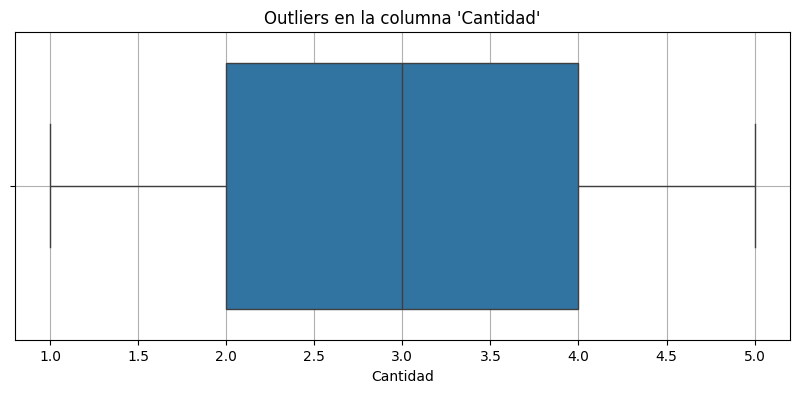

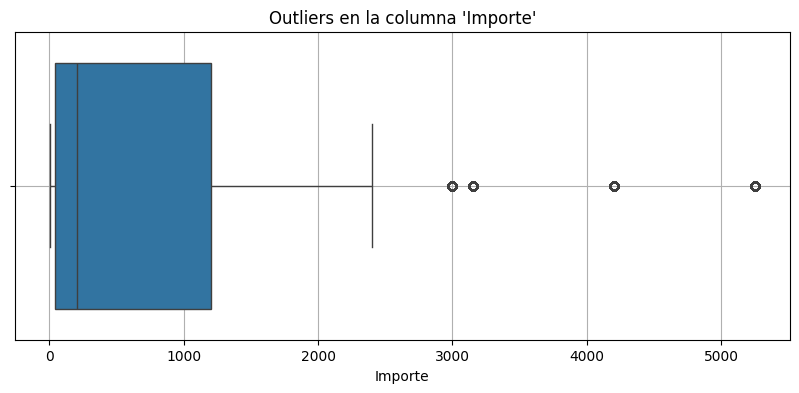

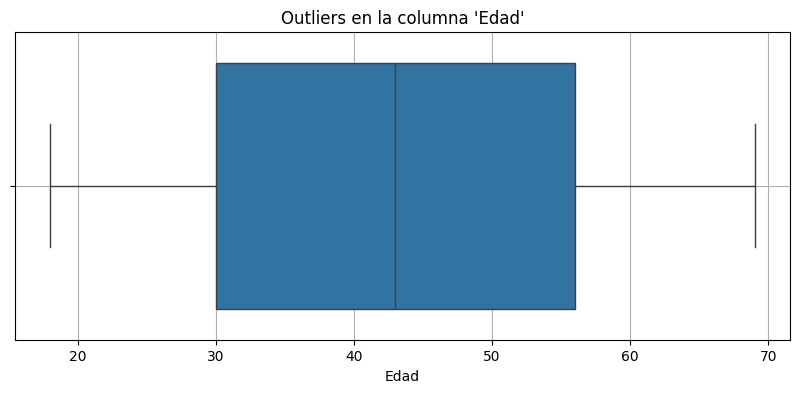

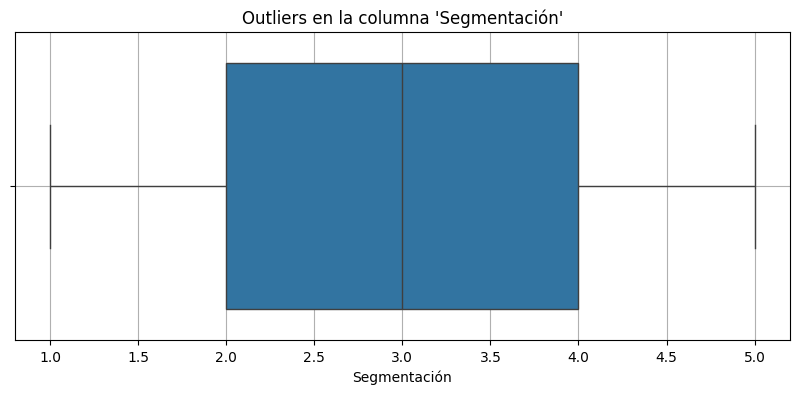

In [118]:
#Visualizamos los outliers para cada columna numérica

for columna in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=df[columna])
    plt.title(f"Outliers en la columna '{columna}'")
    plt.grid(True)
    plt.show()


In [119]:
#Vamos a crear una funcion que nos diga exactamente cuales son los outliers de una columna
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    return outliers

In [120]:
# Vamos a ver cuales son los registros outliers de Importe, ya que viendo las gráficas es en la única columna donde existen outilers, osea valores que se alejan de los valores "normales"
# que serían los datos que están entre el Q1 y el Q3
outliers_importe = detectar_outliers(df, "Importe")

# Mostrar los outliers
print(outliers_importe)

        Factura ID_Cliente    Categoría  Cantidad  Importe  Método de Pago  \
3       I000004    C988172    Zapatería         5  3000.85  Otras Tarjetas   
15      I000016    C362288    Zapatería         5  3000.85  Otras Tarjetas   
23      I000024    C313348  Electrónica         5  5250.00        Efectivo   
53      I000054    C626042  Electrónica         4  4200.00        Efectivo   
69      I000070    C236859  Electrónica         5  5250.00  Otras Tarjetas   
...         ...        ...          ...       ...      ...             ...   
499779  I499780    C999070   Juguetería         5  3000.85        Efectivo   
499870  I499871    C999624   Juguetería         3  3150.00        Efectivo   
499871  I499872    C999624   Juguetería         3  3150.00        Efectivo   
499872  I499873    C999624   Juguetería         3  3150.00        Efectivo   
499880  I499881    C999652         Moda         4  4200.00     Tarjeta ECI   

       Fecha_Factura Centro_Comercial          Canal     Género

##### Aunque tengamos outliers en el importe, los vamos a conservar ya que vamos a aplicar un modelo RandomForest, el cual es robusto a outliers y además el que existan clientes con un importe tan alto es bueno para nuestro propósito que es segmentar a los clientes por sus gastos y frecuencia de compra, para después aplicarlo a campañas comerciales.

In [121]:
#Asegurar formatos, sobretodo para el campo fecha, vamos a asegurarnos que tiene el formato requerido
df['Fecha_Factura'] = pd.to_datetime(df['Fecha_Factura'], format="%d/%m/%Y")
df['Factura'] = df['Factura'].astype(str)
 


---

## 3. Preprocesamiento de las variables

In [122]:
#Una vez analizados y limpiados los datos, vamos a realizar una agrupación de los clientes, ya que en nuestro dataset tenemos
# registros con igual cliente pero en el que los demás datos son diferentes

today = df['Fecha_Factura'].max()
 
#Vamos a calcular:
# Importe:
#   - El importe total del cliente
#   - El importe medio por compra.
# Factura:
#   - Contaremos el número de facturas que tiene el cliente para obtener la frecuencia de compra
#   - Obtendremos el número de días que han pasado desde la última factura
# Categoría:
#   - Nos quedamos con la categorías más frecuente
#Lo mismo hacemos para Canal y Metodo de pago

cliente_df = df.groupby('ID_Cliente').agg({
    'Importe': ['sum', 'mean'],
    'Factura': 'count',
    'Fecha_Factura': lambda x: (today - x.max()).days,
    'Categoría': lambda x: x.mode()[0],
    'Canal': lambda x: x.mode()[0],
    'Edad': 'first',
    'Método de Pago': lambda x: x.mode()[0],
    'Género': 'first'
})
cliente_df.head()

Importe          Factura Fecha_Factura     Categoría  \
                sum     mean   count      <lambda>      <lambda>   
ID_Cliente                                                         
C100004     6001.60  1500.40       4           711          Moda   
C100005     2400.68  1200.34       2           110     Zapatería   
C100006      537.60   107.52       5           254    Juguetería   
C100012      156.90    26.15       6           200  Supermercado   
C100019       71.68    35.84       2           634    Juguetería   

                    Canal  Edad  Método de Pago     Género  
                 <lambda> first        <lambda>      first  
ID_Cliente                                                  
C100004     Tienda física    61  Otras Tarjetas  Masculino  
C100005     Tienda física    34        Efectivo  Masculino  
C100006     Tienda física    44  Otras Tarjetas  Masculino  
C100012     Tienda física    25        Efectivo  Masculino  
C100019     Tienda física    21  Otras Tarjetas   Femenino

In [123]:
#Renombramos las columnas
cliente_df.columns = ['Importe_total', 'Ticket_medio', 'Frecuencia', 'Dias_desde_ultima_factura', 'Categoria_top', 'Canal_preferido', 'Edad', 'Metodo_pago', 'Genero']
cliente_df.reset_index(inplace=True)
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero
0,C100004,6001.60,1500.40,4,711,Moda,Tienda física,61,Otras Tarjetas,Masculino
1,C100005,2400.68,1200.34,2,110,Zapatería,Tienda física,34,Efectivo,Masculino
2,C100006,537.60,107.52,5,254,Juguetería,Tienda física,44,Otras Tarjetas,Masculino
3,C100012,156.90,26.15,6,200,Supermercado,Tienda física,25,Efectivo,Masculino
4,C100019,71.68,35.84,2,634,Juguetería,Tienda física,21,Otras Tarjetas,Femenino


In [124]:
#Vamos a obtener la columna Segmento Economico para clasificar a los clientes en 5 categorías, teniendo en cuenta 
# - Importe total
# - Frecuencia compra
# # - Numero dias desde la ultima compra
#Esto lo hacemos para poder crear un clasificador multilabel

# Selección y escalado de variables
X = cliente_df[['Importe_total', 'Frecuencia', 'Dias_desde_ultima_factura']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
cliente_df['Cluster_Economico'] = kmeans.fit_predict(X_scaled)

In [125]:
cluster_summary = cliente_df.groupby('Cluster_Economico')[['Importe_total', 'Frecuencia', 'Dias_desde_ultima_factura']].mean().round(2)
print(cluster_summary)


                   Importe_total  Frecuencia  Dias_desde_ultima_factura
Cluster_Economico                                                      
0                       13832.39        5.16                     268.39
1                        1399.26        2.33                     844.79
2                        1669.02        3.24                     268.01
3                        2224.54        5.78                     228.25


In [126]:
cluster_labels = {
    0: 'Clientes Estrella',
    1: 'Compradores de Temporada',
    2: 'Cazadores de Ofertas',
    3: 'Curiosos o Ocasionales'
}

cliente_df['Segmento_Cluster_Economico'] = cliente_df['Cluster_Economico'].map(cluster_labels)
cliente_df.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero,Cluster_Economico,Segmento_Cluster_Economico
0,C100004,6001.60,1500.40,4,711,Moda,Tienda física,61,Otras Tarjetas,Masculino,1,Compradores de Temporada
1,C100005,2400.68,1200.34,2,110,Zapatería,Tienda física,34,Efectivo,Masculino,2,Cazadores de Ofertas
2,C100006,537.60,107.52,5,254,Juguetería,Tienda física,44,Otras Tarjetas,Masculino,3,Curiosos o Ocasionales
3,C100012,156.90,26.15,6,200,Supermercado,Tienda física,25,Efectivo,Masculino,3,Curiosos o Ocasionales
4,C100019,71.68,35.84,2,634,Juguetería,Tienda física,21,Otras Tarjetas,Femenino,1,Compradores de Temporada



---

## 4. Modelado

In [127]:
# Asegurar que la variable objetivo sea numérica
le_cluster = LabelEncoder()
cliente_df['Segmento_Cluster_Cod'] = le_cluster.fit_transform(cliente_df['Segmento_Cluster_Economico'])
# Clonar el dataframe
df_encoded = cliente_df.copy()
label_encoders = {}

# Aplicar LabelEncoder a cada columna categórica
for col in ['Categoria_top', 'Canal_preferido', 'Metodo_pago', 'Genero']:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le 
    
# Definir X e y
X_multi = df_encoded[['Ticket_medio','Edad', 'Categoria_top', 'Genero']]
y_multi = df_encoded['Segmento_Cluster_Cod']


# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_multi, y_multi, test_size=0.3, random_state=42, stratify=y_multi
)


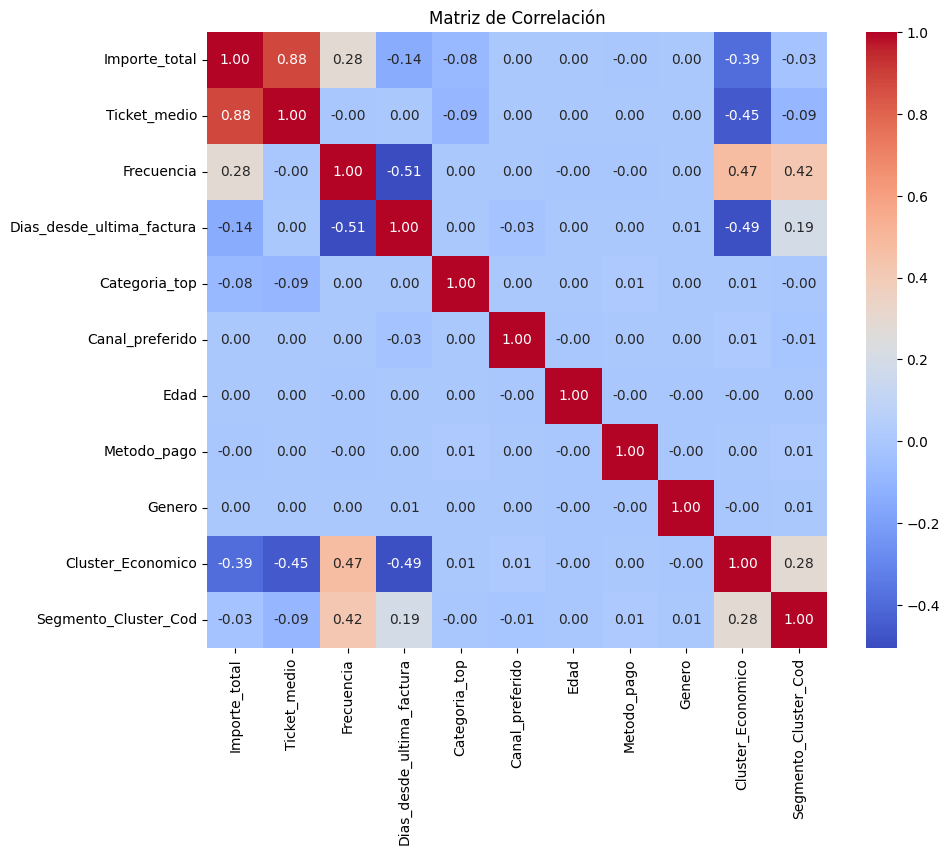

In [128]:
#Vamos a ver la matriz de correlacion
df_corr = df_encoded.drop(columns=['ID_Cliente', 'Segmento_Cluster_Economico'])
correlacion = df_corr.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

Vamos a usar PCA con KNN para lo siguiente:  
    Reducir el espacio a menos dimensiones, ayudando a evitar la "maldición de la dimensionalidad"  
    Elliminar redundancia  
    Priorizra componentes con más varianza útil  
    Reducir el tamaño del input  

In [129]:
# Escalamos los datos (muy importante para PCA y KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) 

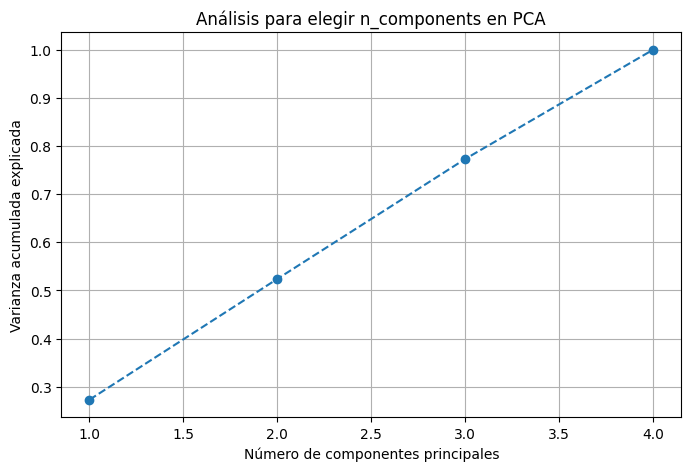

In [130]:
#Para poder tener un modelo lo mejor posible, vamos a calcular cuál sería el mejor n_components para el PCA y el mejor
# n_neighbors para el modelo KNN

#Primero calculamos el n_components
#Calculamos la varianza y la graficamos
pca_full = PCA()
pca_full.fit(X_train_scaled)
var_cumsum = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(var_cumsum)+1), var_cumsum, marker='o', linestyle='--')
plt.xlabel('Número de componentes principales')
plt.ylabel('Varianza acumulada explicada')
plt.title('Análisis para elegir n_components en PCA')
plt.grid(True)
plt.show()

¿Qué es la varianza en PCA?
La varianza mide qué tanto “cambia” o “varía” la información en tus datos.

Cuando aplicas PCA, cada componente principal captura cierta cantidad de esa varianza total.

La suma de la varianza explicada por todas las componentes es igual a toda la información original (100%).

¿Por qué no usar todas las componentes?
Usar todas las componentes es igual que no hacer reducción: no reduces dimensionalidad.

El objetivo de PCA es reducir las variables sin perder mucha información.

Por eso, se busca usar solo las primeras k componentes que ya expliquen casi toda la varianza.

¿Qué significa explicar el 95% de la varianza?
Significa que las primeras k componentes juntas capturan el 95% de la información contenida en los datos originales.

El otro 5% es ruido o información menos importante.

Así, reduces dimensionalidad y mantienes casi toda la información útil.

In [131]:
#Elegimos el número de componentes que expliquen al menos 95% de varianza
n_components = np.argmax(var_cumsum >= 0.95) + 1
print(f"Número de componentes para explicar 95% varianza: {n_components}")

Número de componentes para explicar 95% varianza: 4


In [132]:
# Reducimo dimensionalidad con PCA, nos quedamos con el 95% de los datos y quitams el 5% de ruido
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [133]:
# Aplicar SMOTE al conjunto de entrenamiento transformado
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

In [134]:
#Una vez obtenido el pca, vamos a buscar el mejor n_neighbors con validación cruzada
param_grid = {'n_neighbors': list(range(1, 21))}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_resampled, y_train_resampled)

best_k = grid.best_params_['n_neighbors']
print(f"Mejor número de vecinos (K): {best_k}")

Mejor número de vecinos (K): 20


In [135]:
# Entrenamos el modelo KNN final con los mejores parámetros
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(n_neighbors=20)

Clase: 0 - Cantidad: 37322
Clase: 1 - Cantidad: 6648
Clase: 2 - Cantidad: 23845
Clase: 3 - Cantidad: 24041


<Axes: title={'center': 'Distribución de clases'}, xlabel='Segmento_Cluster_Cod'>

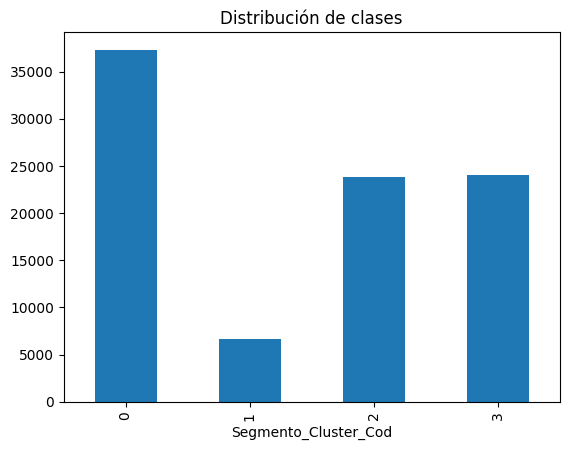

In [136]:
# Si y_train es una Serie o array
valores, conteos = np.unique(y_train, return_counts=True)

# Mostrar cuántas clases hay y cuántos ejemplos tiene cada una
for valor, cuenta in zip(valores, conteos):
    print(f"Clase: {valor} - Cantidad: {cuenta}")

# O en formato tabla (si usas pandas)
pd.Series(y_train).value_counts().sort_index().plot(kind='bar', title='Distribución de clases')


Precisión en test: 0.36671916277179434
Reporte de clasificación:
                          precision    recall  f1-score   support

    Cazadores de Ofertas       0.44      0.36      0.40     15995
       Clientes Estrella       0.46      0.88      0.61      2850
Compradores de Temporada       0.28      0.29      0.29     10220
  Curiosos o Ocasionales       0.31      0.31      0.31     10303

                accuracy                           0.37     39368
               macro avg       0.37      0.46      0.40     39368
            weighted avg       0.37      0.37      0.36     39368



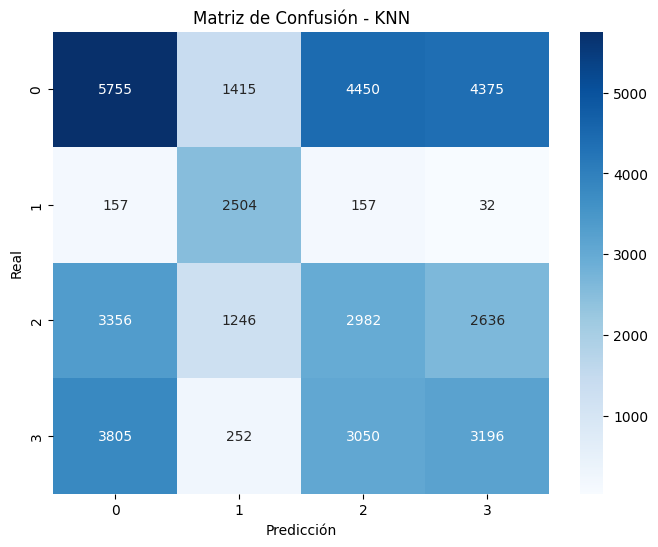

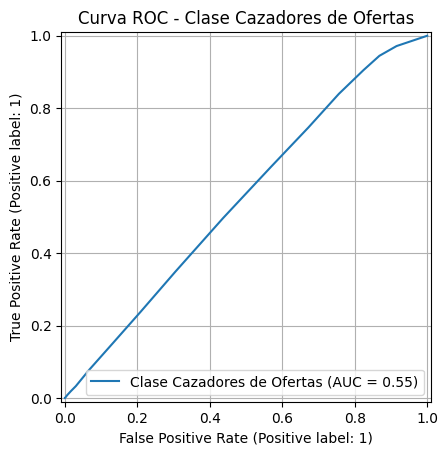

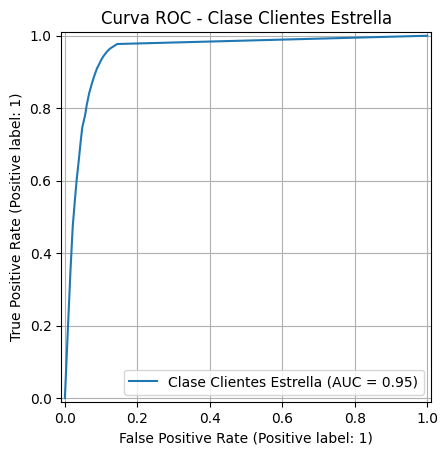

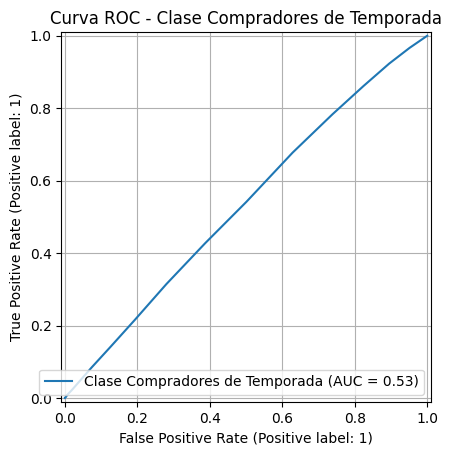

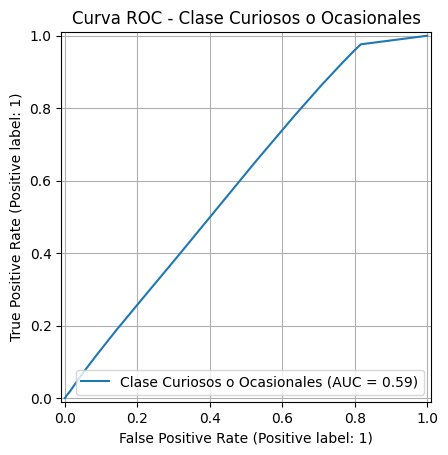

AUC-ROC (multiclase): 0.66


In [137]:
y_pred = knn.predict(X_test_pca)

print("\nPrecisión en test:", accuracy_score(y_test, y_pred))
y_proba = knn.predict_proba(X_test_pca)

# Reporte de clasificación
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le_cluster.classes_))

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - KNN")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# Curvas ROC por clase
y_test_bin = label_binarize(y_test, classes=np.unique(y_multi))
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
 RocCurveDisplay.from_predictions(y_test_bin[:, i], y_proba[:, i], name=f"Clase {le_cluster.classes_[i]}")
 plt.title(f"Curva ROC - Clase {le_cluster.classes_[i]}")
 plt.grid(True)
 plt.show()

# AUC-ROC multiclase
auc_roc = roc_auc_score(y_test_bin, y_proba, multi_class='ovr')
print(f"AUC-ROC (multiclase): {auc_roc:.2f}")


In [138]:
#Guardamos modelo, scaler, encoder, PCA

# Guardar modelo entrenado
joblib.dump(knn, './Modelos/modelo_knn.pkl')

# Guardar scaler
joblib.dump(scaler, './Modelos/scaler.pkl')

# Guardar PCA
joblib.dump(pca, './Modelos/pca.pkl')

# Guardar LabelEncoders
for col, le in label_encoders.items():
    joblib.dump(le, f'labelencoder_{col}.pkl')

Categoria_top               Electrónica  Supermercado
Segmento_Cluster_Economico                           
Cazadores de Ofertas          24.090702     42.305699
Clientes Estrella             43.691980      1.937824
Compradores de Temporada      20.864404     26.595855
Curiosos o Ocasionales        11.352914     29.160622


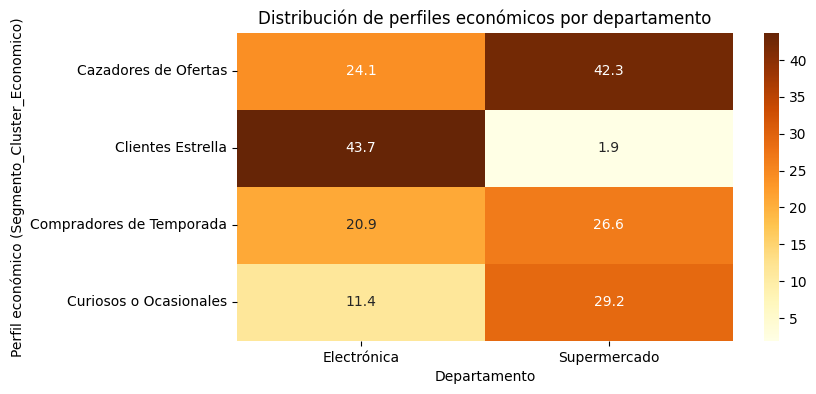

In [142]:
departamentos_objetivo = ['Electrónica', 'Supermercado']
df_filtro = cliente_df[cliente_df['Categoria_top'].isin(departamentos_objetivo)]

tabla = pd.crosstab(df_filtro['Segmento_Cluster_Economico'], df_filtro['Categoria_top'], normalize='columns') * 100
print(tabla)

plt.figure(figsize=(8, 4))
sns.heatmap(tabla, annot=True, fmt=".1f", cmap="YlOrBr")
plt.title("Distribución de perfiles económicos por departamento")
plt.ylabel("Perfil económico (Segmento_Cluster_Economico)")
plt.xlabel("Departamento")
plt.show()




In [141]:
df_encoded.head()

,ID_Cliente,Importe_total,Ticket_medio,Frecuencia,Dias_desde_ultima_factura,Categoria_top,Canal_preferido,Edad,Metodo_pago,Genero,Cluster_Economico,Segmento_Cluster_Economico,Segmento_Cluster_Cod
0,C100004,6001.60,1500.40,4,711,3,0,61,1,1,1,Compradores de Temporada,2
1,C100005,2400.68,1200.34,2,110,7,0,34,0,1,2,Cazadores de Ofertas,0
2,C100006,537.60,107.52,5,254,1,0,44,1,1,3,Curiosos o Ocasionales,3
3,C100012,156.90,26.15,6,200,6,0,25,0,1,3,Curiosos o Ocasionales,3
4,C100019,71.68,35.84,2,634,1,0,21,1,0,1,Compradores de Temporada,2
